# July 1st, 2021

**Motivation**: Mouse meeting presentation. <br>


In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')

# GitHub
sys.path.insert(0, pjoin(git_dir, 'Ca-fMRI'))
from register.atlas import load_allen, make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.helper import *
from utils.plotting import *
from utils.render import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE



def hierarchical_compare(
        hierarchical: dict,
        n_clusters: Union[range, list],
        key_fx: str = 'sub-SLC',
        keys_mv: List[str] = None,
        dist_measure: str = 'dice',
        cmap='RdYlBu_r',
        figsize=None, ):
    
    allen = hierarchical[key_fx].mice.allen
    contour = hierarchical[key_fx].mice.parcel.results2d['contour']
    
    keys_mv = keys_mv if keys_mv else ['ses-1', 'ses-2', 'ses-3']
    nrows, ncols = len(keys_mv) + 1, len(n_clusters)
    figsize = figsize if figsize else (13.5, 1.75 * nrows)
    fig, axes = create_figure(nrows, ncols, figsize=figsize)

    match_results = {}
    for j, n in tqdm(enumerate(n_clusters), total=len(n_clusters), leave=False):
        fx_masks = hierarchical[key_fx].results[n]['cluster_masks']
        _, x2d = masks2cluster(fx_masks, allen)
        
        cond = np.logical_or(contour, x2d == 0)
        _cond, _x = filter_boundaries([cond, x2d], mask=x2d.astype(bool))
        data2plt = np.ma.masked_where(_cond, _x)
        axes[0, j].imshow(data2plt, cmap=cmap)
        axes[0, j].set_title(f"n = {n}", fontsize=17, y=1.06)
        if j == 0:
            axes[0, j].set_ylabel(f"{key_fx}\n", fontsize=15)

        for i, key in enumerate(keys_mv):
            mv_masks = hierarchical[key].results[n]['cluster_masks']
            scores, mappings = clusters_sim_scores(fx_masks, mv_masks, weighted=True)
            match_results['_vs_'.join([key_fx, key])] = (scores, mappings)

            algn_idxs = list(mappings[dist_measure].values())
            mv_algn = dict(zip(
                list(mv_masks),
                np.array(list(mv_masks.values()))[algn_idxs]
            ))
            _, x2d_algn = masks2cluster(mv_algn, allen)

            cond = np.logical_or(contour, x2d_algn == 0)
            _cond, _x = filter_boundaries([cond, x2d_algn], mask=x2d_algn.astype(bool))
            data2plt = np.ma.masked_where(_cond, _x)
            axes[i + 1, j].imshow(data2plt, cmap=cmap)
            if j == 0:
                axes[i + 1, j].set_ylabel(f"{key}\n", fontsize=14)
    remove_ticks(axes)
    return fig, axes, match_results

## Tree graphs

### 0) Root

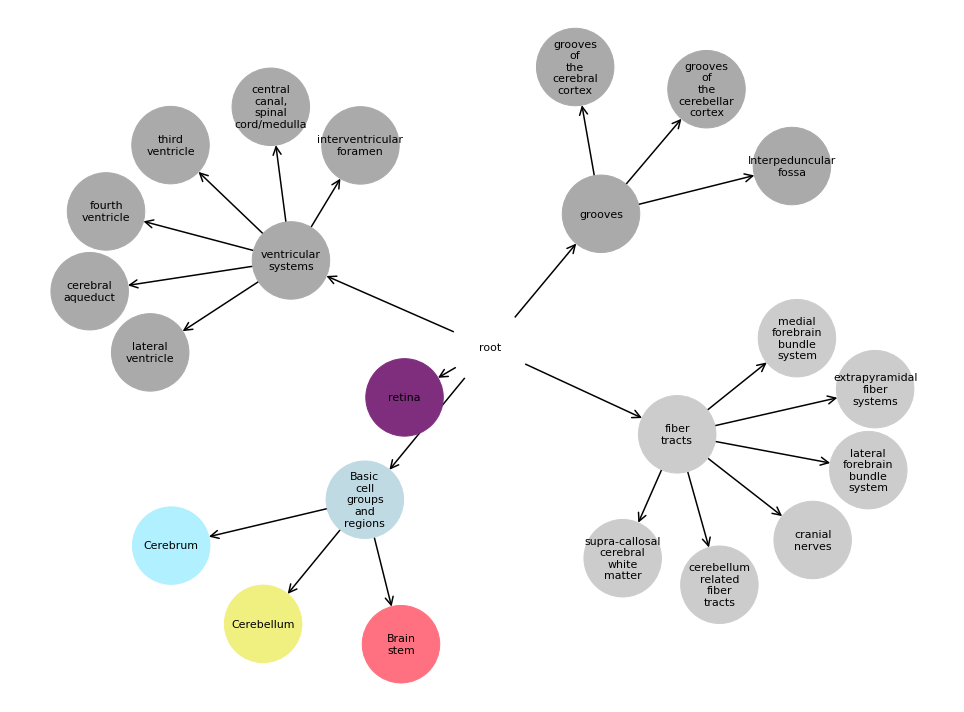

In [3]:
n_levels = 3
root = 'root'
tree = make_tree_graph(root, n_levels=n_levels, use_acroym=False)

_ = plot_nx_tree(tree, 'neato', node_size=6000)

### 1) Cerebrum

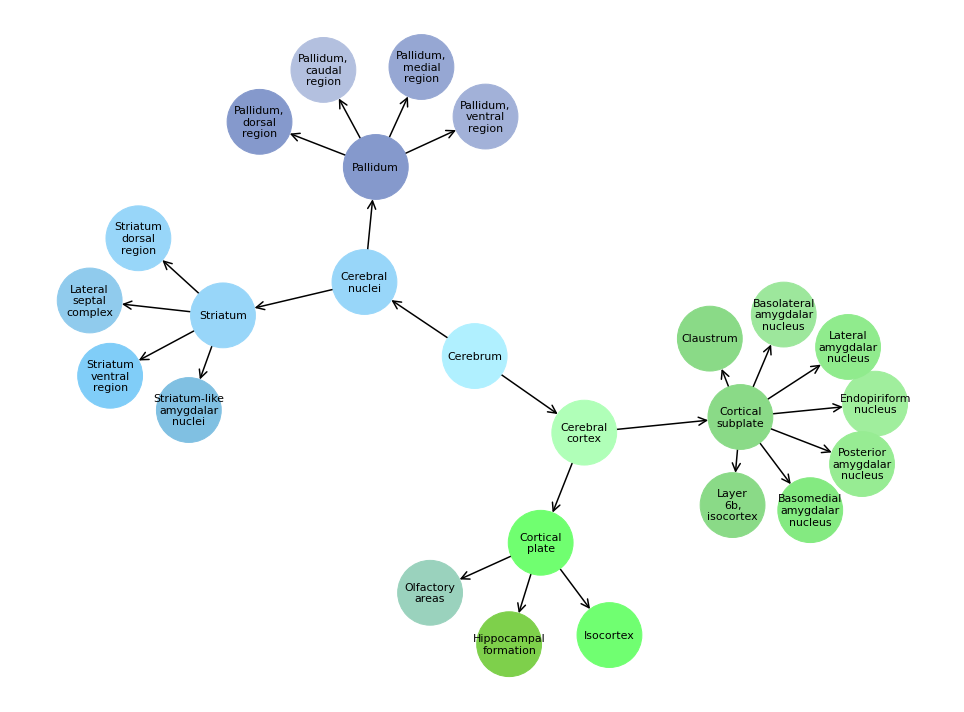

In [4]:
n_levels = 4
root = 'Cerebrum'
tree = make_tree_graph(root, n_levels=n_levels, use_acroym=False)

_ = plot_nx_tree(tree, 'neato')

### 2) Isocortex

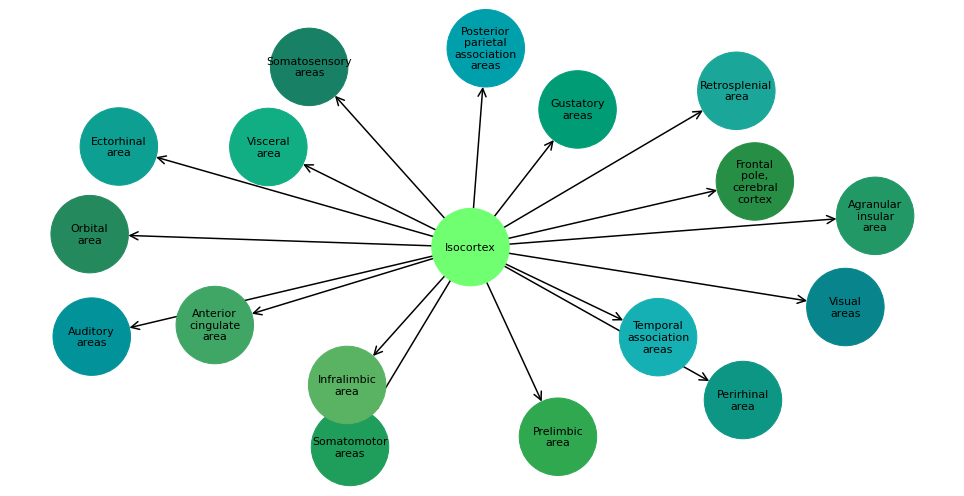

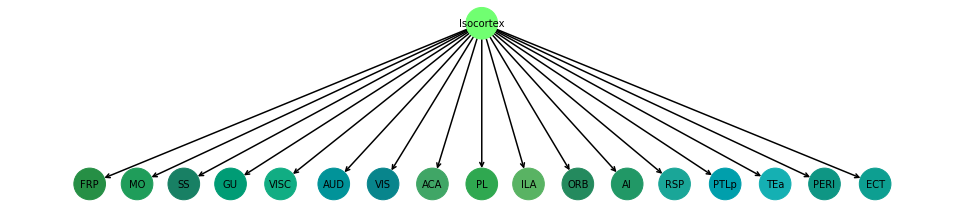

In [5]:
n_levels = 2
root = 'Isocortex'
tree = make_tree_graph(root, n_levels=n_levels, use_acroym=False)

_ = plot_nx_tree(tree, 'neato', figsize=(13.5, 7), arrowsize=20, node_size=6000)


n_levels = 2
root = 'Isocortex'
tree = make_tree_graph(root, n_levels=n_levels, use_acroym=True)

_ = plot_nx_tree(tree, 'dot', figsize=(13.5, 3), arrowsize=10, node_size=1000)

## ROI definition

In [3]:
mice = Mice(Config(128))
mice.combine_dfs('rest')

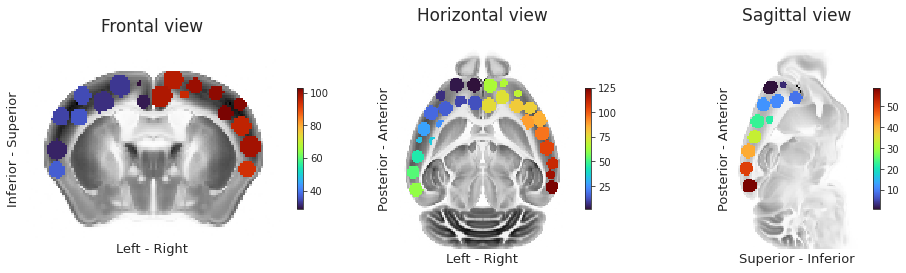

In [4]:
# HIDE CODE


space = AnatomicalSpace('asl')
fig, axes = create_figure(1, 3, figsize=(13, 3.9))

slice_idxs = [58, 30, 44]
for i, (ax, plane, labels) in enumerate(zip(axes, space.sections, space.axis_labels)):
    data2plt = mice.parcel.results['eroded'].take(slice_idxs[i], axis=i)
    data2plt = np.ma.masked_where(data2plt == 0, data2plt)
    ax.imshow(mice.allen['template'].take(slice_idxs[i], axis=i), cmap='Greys')
    im = ax.imshow(data2plt, cmap='turbo')
    plt.colorbar(im, ax=ax, shrink=0.6)
    
    ax.set_title(f"{plane.capitalize()} view\n", fontsize=17)
    ax.set_ylabel(labels[0], fontsize=13)
    ax.set_xlabel(labels[1], fontsize=13)

    _ = list(map(lambda x: x.set_visible(False), ax.spines.values()))
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
plt.show()

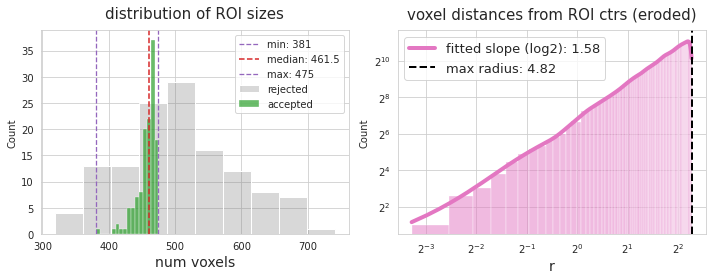

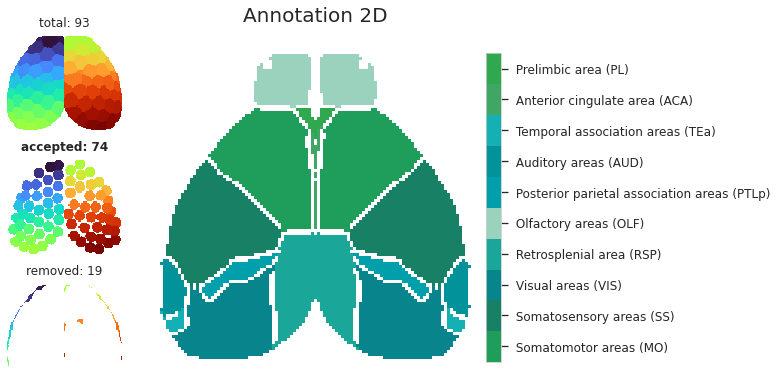

In [5]:
_ = mice.parcel.show()
_ = mice.parcel.show_2d()

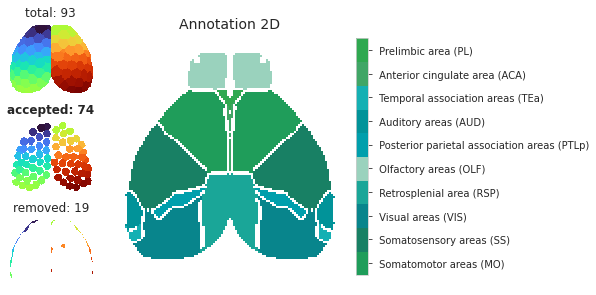

In [6]:
fig, _ = mice.parcel.show_2d(
    figsize=(8.4, 4.2), fontsize_big=14,
    plt_kwrgs={'shrink': 0.9, 'pad': 0.08, 'ctick_labelsize': 10, 'ctick_length': 4, 'ctick_width': 0.8}
)
fig.savefig(pjoin(tmp_dir, f"annot2d_{now()}.pdf"), bbox_inches='tight', dpi=600)

## Hierarchical

In [7]:
hier = Hierarchical(
    mice=mice,
    key='sub-SLC',
    metric='correlation',
).fit(range(16)).make_clusters()

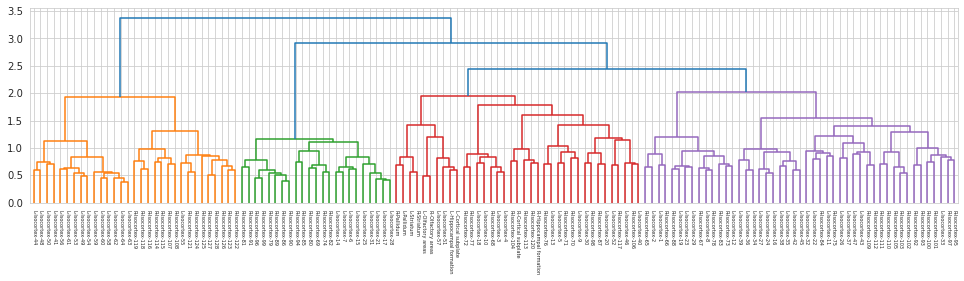

In [10]:
name = f"hier{mice.parcel.results['n_cortical_regions']}_{now()}.pdf"
fig = hier.results[0]['fig']
fig.savefig(pjoin(tmp_dir, name), bbox_inches='tight', dpi=600)
display(fig)

In [11]:
for n in range(2, 9):
    _ = cluster2html(
        cluster=hier.clusters[n],
        save_name='CORR-REST',
        n_cortex_regions=hier.mice.parcel.results['n_cortical_regions'],
        save_dir=extras_dir,
    )

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-128_n-2.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-128_n-3.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-128_n-4.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-128_n-5.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-128_n-6.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-128_n-7.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-128_n-8.html

In [97]:
hier.clusters[6].export(extras_dir, f"CORR-REST-{hier.mice.parcel.results['n_cortical_regions']}")

[PROGRESS] 'CORR-REST-128-regions_n-6.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'CORR-REST-128-clusters_n-6.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

(
    '/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST-128-regions_n-6.html',
    '/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST-128-clusters_n-6.html'
)

### Embed

In [ ]:
n = 5

#### Render 3d

In [ ]:
file = f"../../_extras/CORR-REST_render-{mice.parcel.results['n_cortical_regions']}_n-{n}.html"
IFrame(file, width=1000, height=700)

#### Overlap table

In [ ]:
file = f"../../_extras/CORR-REST-{mice.parcel.results['n_cortical_regions']}-regions_n-{n}.html"
IFrame(file, width=1000, height=600)

## Load/fit hierarchical results

### 128 - REST

In [114]:
mice = Mice(Config(128))
mice.combine_dfs('rest')

In [115]:
metric = 'correlation'
load_dir = pjoin(mice.cfg.results_dir, f"hierarchical")
load_dir = pjoin(load_dir, sorted([x for x in os.listdir(load_dir) if metric in x])[-1])
c_masks_dir = pjoin(load_dir, 'cluster_masks')

hex2key = np.load(pjoin(load_dir, 'hex2key.npy'), allow_pickle=True).item()
key2hex = {k: h for h, k in hex2key.items()}

load_dir, os.listdir(load_dir)

(
    '/home/hadi/Documents/Ca-fMRI/processed/kmeans-128/results/hierarchical/correlation-(2021_06_30)',
    ['reproduc.df', 'hex2key.npy', 'cluster_masks', 'fits']
)

In [116]:
key_fx = 'sub-SLC'
keys_mv = ['ses-1', 'ses-2', 'ses-3']

hierarchical = {}
for k, f in key2hex.items():
    if k not in keys_mv + [key_fx]:
        continue
    hierarchical[k] = Hierarchical(
        mice=mice,
        metric=metric,
    ).load(f, load_dir, make=False).make_cluster_masks()
list(hierarchical)

['sub-SLC', 'ses-1', 'ses-2', 'ses-3']

  0%|          | 0/2 [00:00<?, ?it/s]

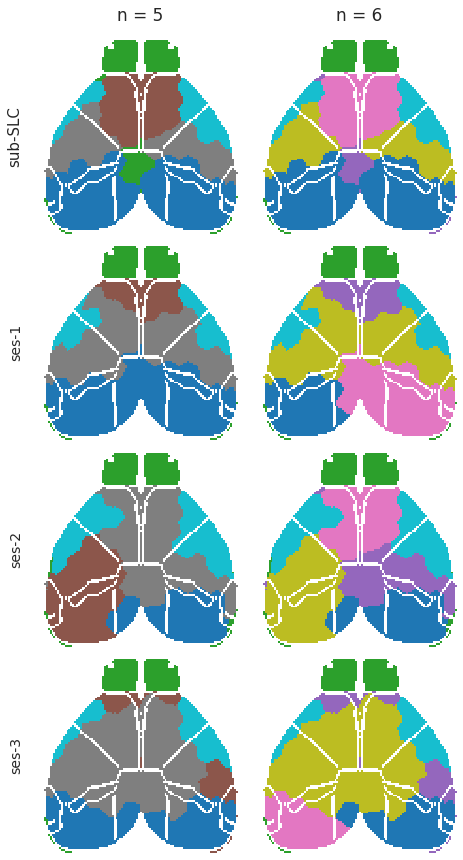

In [128]:
n_clusters = range(5, 7)

fig, axes, match_results = hierarchical_compare(
    hierarchical=hierarchical,
    n_clusters=n_clusters,
    key_fx=key_fx,
    keys_mv=[],
    cmap='tab10',
    figsize=(7, 12),
)

In [129]:
name = f"hier{mice.parcel.results['n_cortical_regions']}_nclusters-{n_clusters}_{now()}.pdf"
name = name.replace(' ', '')
fig.savefig(pjoin(tmp_dir, name), bbox_inches='tight', dpi=600)

  0%|          | 0/5 [00:00<?, ?it/s]

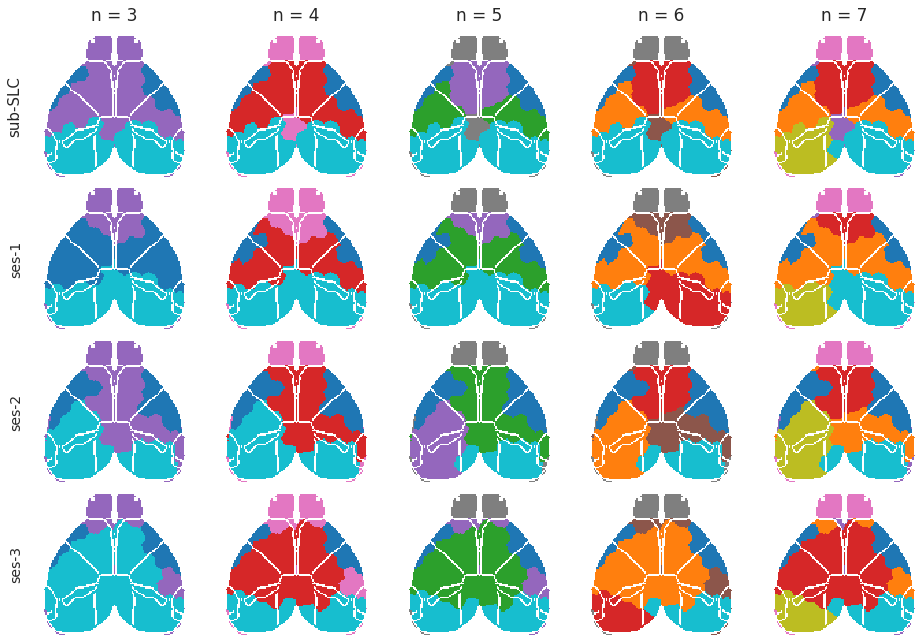

In [48]:
n_clusters = range(3, 8)

fig, axes, match_results = hierarchical_compare(
    hierarchical=hierarchical,
    n_clusters=n_clusters,
    key_fx=key_fx,
    keys_mv=keys_mv,
    cmap='tab10_r',
    figsize=(13.5, 9),
)

In [49]:
name = f"hier{mice.parcel.results['n_cortical_regions']}_nclusters-{n_clusters}_{now()}.pdf"
name = name.replace(' ', '')
fig.savefig(pjoin(tmp_dir, name), bbox_inches='tight', dpi=600)

### 128 - LED

In [50]:
mice = Mice(Config(128))
mice.combine_dfs('led')

In [53]:
key_fx = 'sub-SLC'
keys_mv = ['ses-1', 'ses-2', 'ses-3']

hierarchical = {}
for k in keys_mv + [key_fx]:
    hierarchical[k] = Hierarchical(
        mice=mice,
        key=k,
        metric=metric,
    ).fit(range(2, 10)).make_cluster_masks()
list(hierarchical)

['ses-1', 'ses-2', 'ses-3', 'sub-SLC']

  0%|          | 0/8 [00:00<?, ?it/s]

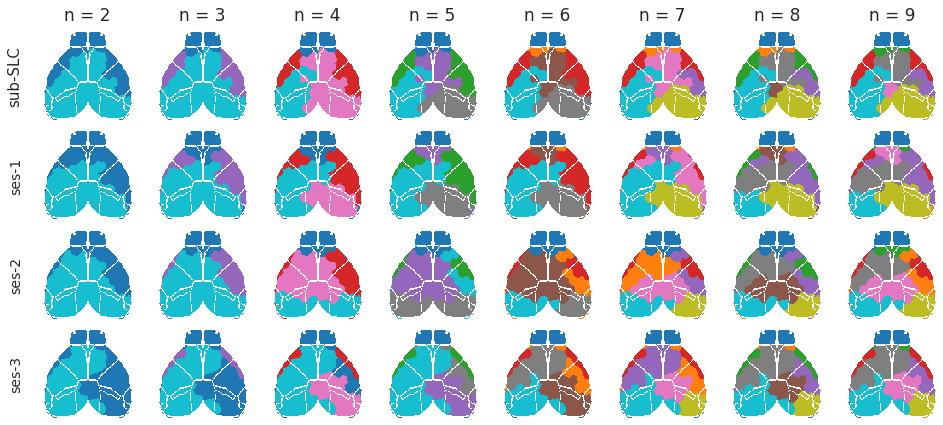

In [54]:
n_clusters = range(2, 10)

fig, axes, match_results = hierarchical_compare(
    hierarchical=hierarchical,
    n_clusters=n_clusters,
    key_fx=key_fx,
    keys_mv=keys_mv,
    cmap='tab10_r',
    figsize=(13.5, 6),
)

In [55]:
name = f"hier{mice.parcel.results['n_cortical_regions']}_LED_nclusters-{n_clusters}_{now()}.pdf"
name = name.replace(' ', '')
fig.savefig(pjoin(tmp_dir, name), bbox_inches='tight', dpi=600)

  0%|          | 0/5 [00:00<?, ?it/s]

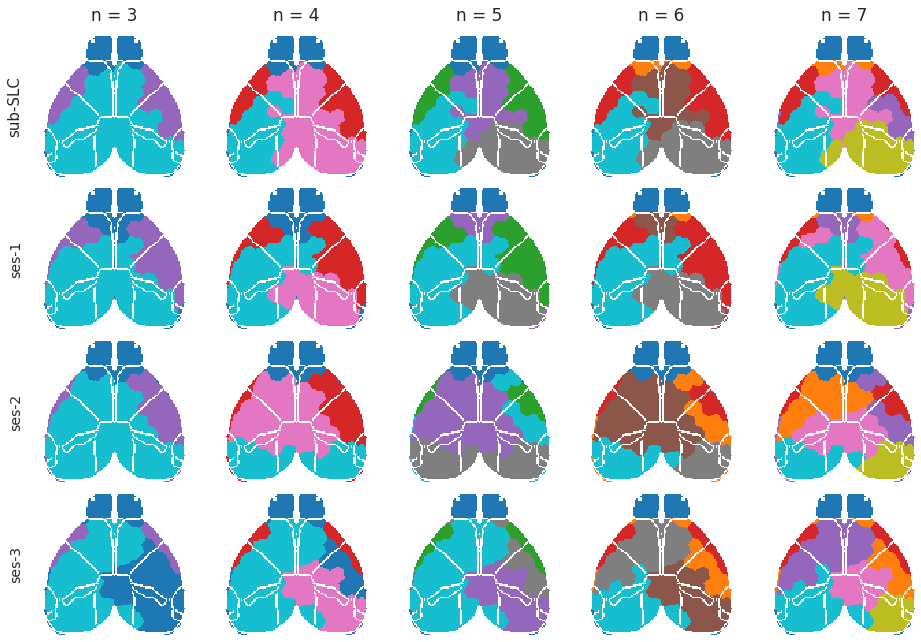

In [56]:
n_clusters = range(3, 8)

fig, axes, match_results = hierarchical_compare(
    hierarchical=hierarchical,
    n_clusters=n_clusters,
    key_fx=key_fx,
    keys_mv=keys_mv,
    cmap='tab10_r',
    figsize=(13.5, 9),
)

In [57]:
name = f"hier{mice.parcel.results['n_cortical_regions']}_LED_nclusters-{n_clusters}_{now()}.pdf"
name = name.replace(' ', '')
fig.savefig(pjoin(tmp_dir, name), bbox_inches='tight', dpi=600)

### 64 - REST

In [78]:
mice = Mice(Config(64))
mice.combine_dfs('rest')

In [79]:
metric = 'correlation'
load_dir = pjoin(mice.cfg.results_dir, f"hierarchical")
load_dir = pjoin(load_dir, sorted([x for x in os.listdir(load_dir) if metric in x])[-1])
c_masks_dir = pjoin(load_dir, 'cluster_masks')

hex2key = np.load(pjoin(load_dir, 'hex2key.npy'), allow_pickle=True).item()
key2hex = {k: h for h, k in hex2key.items()}

load_dir, os.listdir(load_dir)

(
    '/home/hadi/Documents/Ca-fMRI/processed/kmeans-64/results/hierarchical/correlation-(2021_06_30)',
    ['hex2key.npy', 'cluster_masks', 'fits']
)

In [80]:
key_fx = 'sub-SLC'
keys_mv = ['ses-1', 'ses-2', 'ses-3']

hierarchical = {}
for k, f in key2hex.items():
    if k not in keys_mv + [key_fx]:
        continue
    hierarchical[k] = Hierarchical(
        mice=mice,
        metric=metric,
    ).load(f, load_dir, make=False).make_cluster_masks()
list(hierarchical)

['sub-SLC', 'ses-1', 'ses-2', 'ses-3']

  0%|          | 0/8 [00:00<?, ?it/s]

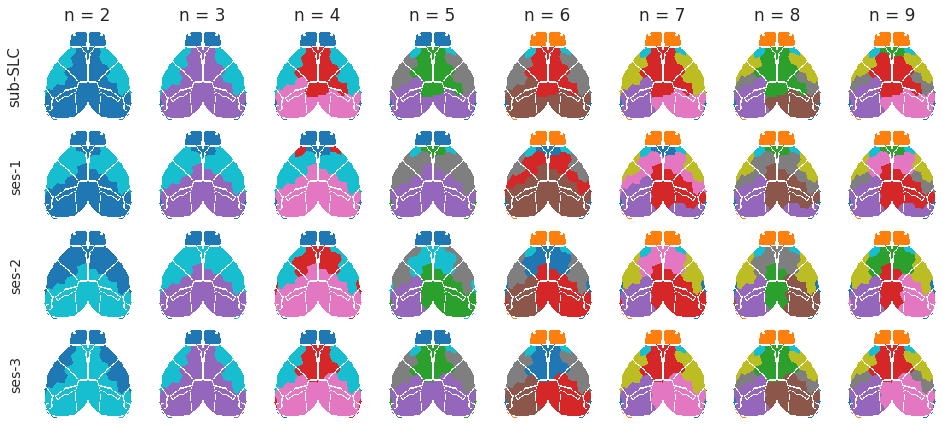

In [81]:
n_clusters = range(2, 10)

fig, axes, match_results = hierarchical_compare(
    hierarchical=hierarchical,
    n_clusters=n_clusters,
    key_fx=key_fx,
    keys_mv=keys_mv,
    cmap='tab10_r',
    figsize=(13.5, 6),
)

In [82]:
name = f"hier{mice.parcel.results['n_cortical_regions']}_nclusters-{n_clusters}_{now()}.pdf"
name = name.replace(' ', '')
fig.savefig(pjoin(tmp_dir, name), bbox_inches='tight', dpi=600)

  0%|          | 0/5 [00:00<?, ?it/s]

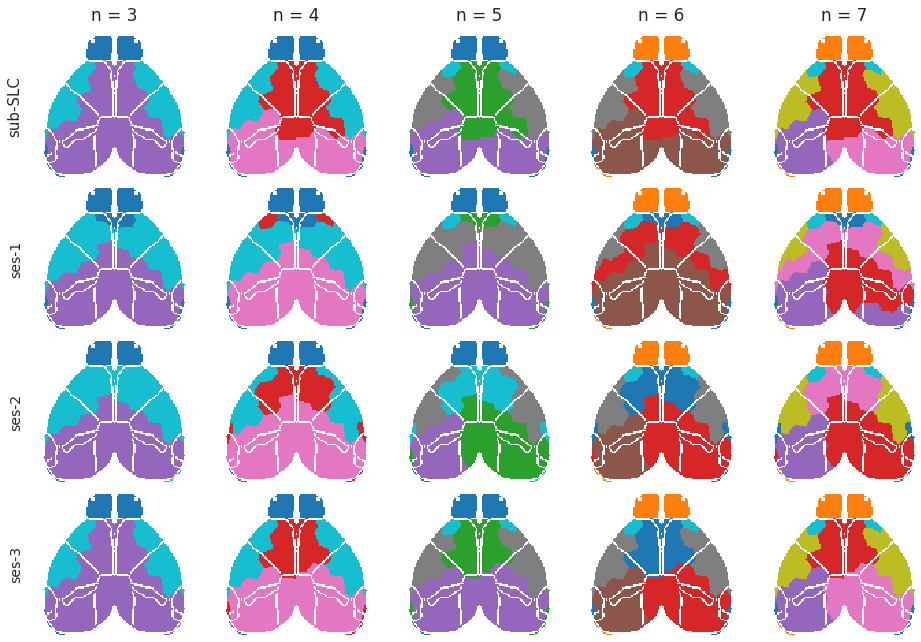

In [83]:
n_clusters = range(3, 8)

fig, axes, match_results = hierarchical_compare(
    hierarchical=hierarchical,
    n_clusters=n_clusters,
    key_fx=key_fx,
    keys_mv=keys_mv,
    cmap='tab10_r',
    figsize=(13.5, 9),
)

In [84]:
name = f"hier{mice.parcel.results['n_cortical_regions']}_nclusters-{n_clusters}_{now()}.pdf"
name = name.replace(' ', '')
fig.savefig(pjoin(tmp_dir, name), bbox_inches='tight', dpi=600)

### 64 - LED

In [91]:
mice = Mice(Config(64))
mice.combine_dfs('led')

In [92]:
key_fx = 'sub-SLC'
keys_mv = ['ses-1', 'ses-2', 'ses-3']

hierarchical = {}
for k in keys_mv + [key_fx]:
    hierarchical[k] = Hierarchical(
        mice=mice,
        key=k,
        metric=metric,
    ).fit(range(2, 10)).make_cluster_masks()
list(hierarchical)

['ses-1', 'ses-2', 'ses-3', 'sub-SLC']

  0%|          | 0/8 [00:00<?, ?it/s]

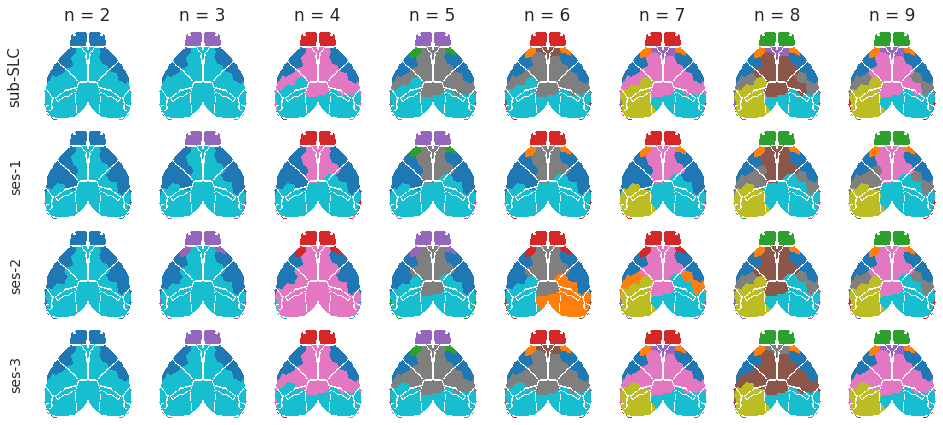

In [93]:
n_clusters = range(2, 10)

fig, axes, match_results = hierarchical_compare(
    hierarchical=hierarchical,
    n_clusters=n_clusters,
    key_fx=key_fx,
    keys_mv=keys_mv,
    cmap='tab10_r',
    figsize=(13.5, 6),
)

In [94]:
name = f"hier{mice.parcel.results['n_cortical_regions']}_LED_nclusters-{n_clusters}_{now()}.pdf"
name = name.replace(' ', '')
fig.savefig(pjoin(tmp_dir, name), bbox_inches='tight', dpi=600)

  0%|          | 0/5 [00:00<?, ?it/s]

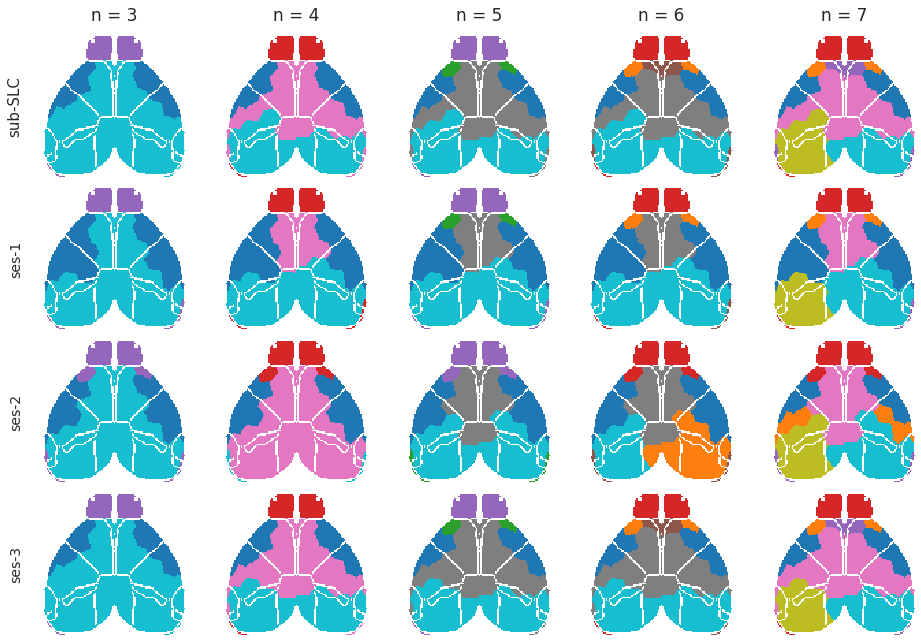

In [95]:
n_clusters = range(3, 8)

fig, axes, match_results = hierarchical_compare(
    hierarchical=hierarchical,
    n_clusters=n_clusters,
    key_fx=key_fx,
    keys_mv=keys_mv,
    cmap='tab10_r',
    figsize=(13.5, 9),
)

In [96]:
name = f"hier{mice.parcel.results['n_cortical_regions']}_LED_nclusters-{n_clusters}_{now()}.pdf"
name = name.replace(' ', '')
fig.savefig(pjoin(tmp_dir, name), bbox_inches='tight', dpi=600)

## Symmetry score

In [107]:
n_clusters = range(2, 10)
metric = 'correlation'
keys = ['sub-SLC', 'ses-1', 'ses-2', 'ses-3']

dict_list = []
for n in tqdm([64, 128, 500, 1024]):
    mice = Mice(Config(n))
    mice.combine_dfs('rest')
    
    load_dir = pjoin(mice.cfg.results_dir, f"hierarchical")
    load_dir = pjoin(load_dir, sorted([x for x in os.listdir(load_dir) if metric in x])[-1])
    c_masks_dir = pjoin(load_dir, 'cluster_masks')
    hex2key = np.load(pjoin(load_dir, 'hex2key.npy'), allow_pickle=True).item()
    key2hex = {k: h for h, k in hex2key.items()}
    
    hierarchical = {}
    for k, f in key2hex.items():
        if k not in keys:
            continue
        hierarchical[k] = Hierarchical(
            mice=mice,
            metric=metric,
        ).load(f, load_dir, make=False).make_cluster_masks()

    for k in keys:
        for n in n_clusters:
            masks = hierarchical[k].results[n]['cluster_masks']
            sym_scores = [
                symmetry_score(m, mice.parcel.results['mask_l'], mice.parcel.results['mask_r'])
                for m in masks.values()
            ]
            data_dict = {
                'n_rois': [mice.parcel.results['n_cortical_regions']],
                'n_clusters': [n],
                'tag': [k],
                'metric': [metric],
                'dist_measure': ['symmetry'],
                'val': [weighted_score(sym_scores, masks)],
                'val_mean': [np.mean(sym_scores)],
                'val_median': [np.median(sym_scores)],
            }
            dict_list.append(data_dict)
sym_df = pd.DataFrame(merge_dicts(dict_list))

  0%|          | 0/4 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

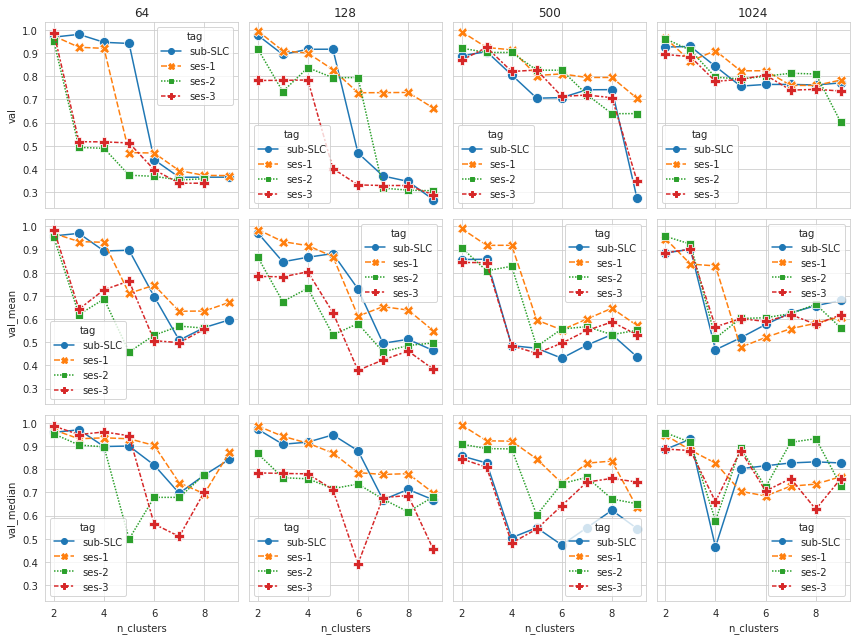

In [110]:
fig, axes = create_figure(3, 4, (12, 9), True, 'whitegrid', 'all', 'all')

for j, n in enumerate(sym_df.n_rois.unique()):
    for i, (ax, val) in enumerate(zip(axes[:, j], ['val', 'val_mean', 'val_median'])):
        selected_df = sym_df.loc[sym_df.n_rois == n]
        sns.lineplot(
            data=selected_df,
            x='n_clusters',
            y=val,
            hue='tag',
            style='tag',
            markers=True,
            markersize=10,
            estimator=np.mean,
            ci='sd',
            alpha=1.0,
            legend=True,
            palette='tab10',
            ax=ax,
        )
        if i == 0:
            ax.set_title(n)
plt.show()

<AxesSubplot:xlabel='n_clusters', ylabel='val_mean'>

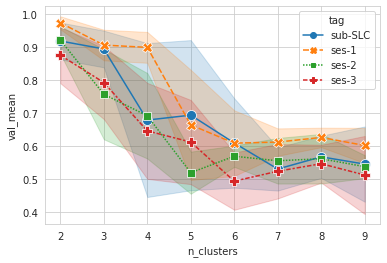

In [113]:
sns.lineplot(
    data=sym_df,
    x='n_clusters',
    y='val_mean',
    hue='tag',
    style='tag',
    markers=True,
    markersize=10,
    estimator=np.mean,
    ci='sd',
    alpha=1.0,
    legend=True,
    palette='tab10',
)